In [1]:
#from compute import Var, Par, Model, adda, addf, ureg, Evaluable, buildidpvars
from compute import Var, Par
from datastructures.api import Model, adda, addf, addsolver
#from compute import RefNode, SolverNode, addsolver, geteqs
from anytree import Node
from constants import μ, R, Q, k, c, G, H_int, ρ_int
from representations import render_tree, digraph_repr, drawfull, tree_incidence
from notation import graphs_from_incidence, make_acyclic, solvers_bottom_up, generate_execution, default_sequence
import numpy as np
import sympy as sp
import networkx as nx
from sympy.utilities.lambdify import implemented_function
import matplotlib.pyplot as plt
from collections import OrderedDict
from datastructures.graphutils import namefromsympy, flat_graph_formulation, Node, COMP, merge_edges, all_varnodes, all_variables, sources
from datastructures.operators import sort_scc, reorder_merge_solve
from datastructures.execution import Component
from datastructures.workflow import order_from_tree, get_f, mdao_workflow, default_solver_options
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.assembly import build_archi
from executeformulations import extractvals

In [2]:
#from polycasebuilder import eqv_to_edges_tree

# Sizing equations

## Parameters

In [3]:
dBtoLinear = lambda db: 10**(db/10)
#EN = Var('EN', 10) #
D_r = Par('D_r', 5.3, 'm')
L = Par('L', dBtoLinear(1+8.5+0.3+0.1)) #based on SMAD page 567
T_s = Par('T_s', 135, 'K')
B = Par('B', 8, 'bit')
N = Par('N', 2e3, '')
eta = Par('eta', 0.55)
l_v = Par('l_v', 500, 'nm')
f = Par('f', 2.2, 'GHz')
rho_T = Par('rho_T', 500e3, 'kg*m')
rho_P = Par('rho_P', 0.002e-3, 'kg/J')
P_l = Par('P_l', 12, 'W')
m_c = Par('m_c', 0.2, 'kg')
C_D = Par('C_D', 2.2)
I_sp = Par('Isp', 70, 's')
w_W = Par('w_W', 1000, 'rad/s')
c_W = Par('c_W', 1)
rho_M = Par('rho_M', 11.4)
rho_P2 = Par('rho_P2', 9/0.1)
M_B = Par('M_B', 7.96e15)
kp = Par('kp', 0.0002)

In [4]:
model = Model()
m = model.root

## Orbit

In [5]:
orbit = m#addsolver(m, name='orbit')

In [6]:
h = Var('h', 400, 'km') #
a = adda(orbit, 'a', h + R, unit='km')
T = adda(orbit, 'T', 2*np.pi*(a**3/μ)**0.5, unit='min')
g = adda(orbit, 'g', 1/np.pi*sp.acos(R/a))
d = adda(orbit, 'd', g+0.5)
r = adda(orbit, 'r', (h**2+2*R*h)**0.5, unit='km')

## Power

In [10]:
power = m#addsolver(m, name='power')

In [11]:
eta_A = Par('eta_A', 0.3)
rho_A = Par('rho_A', 10, 'kg/m^2') #
#ρ_A, η_A = ρ_Ai[solar], η_Ai[solar]
A = Var('A', 0.05, unit='m^2')
m_A = adda(power, 'm_A', rho_A*A)
P_c = adda(power, 'P_c', d*A*Q*eta_A, unit='W')
P_T = adda(power, 'P_T', P_c-P_l) #hack
E_b = adda(power, 'E_b', P_c*T/d)
rho_b = Par('rho_b', 0.002, 'kg/kJ')
m_b = adda(power, 'm_b', rho_b*E_b, unit='kg')
#E_b, m_b = E_bi[bat], m_bi[bat]

## Payload

In [12]:
payload = m#addsolver(m, name='payload')

In [13]:
X_r = Var('X_r', 5, 'm')
D_p = adda(payload, 'D_p', 1.22*l_v*h/X_r)
D = adda(payload, 'D', 2*np.pi*R*B*N/X_r, unit='MB')
rho_p = Par('rho_p', 2, 'kg/m^1.5') 
#D_p, m_p = D_pi[payload], m_pi[payload]
m_p = adda(payload, 'm_p', rho_p*D_p**1.5, unit='kg')

In [14]:
#payload = addsolver(m, geteqs(m, [D_p, D, m_p]), [], name='payload')

## Comms

In [15]:
comms = m#addsolver(m, name='comms')

In [16]:
b = adda(comms, 'b', D/T, unit='MB/s')
λ_c = adda(comms, 'l_c', c/f, unit='cm')
G_T = Par('G_T', dBtoLinear(16.5), '')
D_T = adda(comms, 'D_T', λ_c*(G_T/eta)**0.5/np.pi, unit='m')
rho_T = Par('rho_T', 0.2, 'kg/m^1.5')
m_T = adda(comms, 'm_T', rho_T*D_T**1.5, unit='kg')
#m_T, P_T, G_T = m_Ti[comms], P_Ti[comms], G_Ti[comms]
G_r = adda(comms, 'G_r', eta*(np.pi*D_r/λ_c)**2)
EN = adda(comms, 'EN', P_T*G_r*G_T/(L*k*T_s*b)*(λ_c/(4*np.pi*r))**2, unit='')

In [17]:
#comms = addsolver(m, geteqs(m, [b, λ_c, D_T, m_T, G_r, EN]), [], name='comms')

In [18]:
# For verification against budget in SMAD
# model = Model()
# m = RefNode(name='/', ref=model)
# dBtoLinear = lambda db: 10**(db/10)
# r = Par('r', 2831, 'km')
# P_T = Par('P_T', 20, 'W')
# D_r = Par('D_r', 5.3, 'm')
# D_T = Par('D_T', 0.3, 'm')
# L = Par('L', 9.77)
# T_s = Par('T_s', 135, 'K')
# eta = Par('eta', 0.55)
# f = Par('f', 2.2, 'GHz')
# b = Par('b', 85, unit='Mbit/s')
# λ_c = adda(m, 'l_c', c/f, unit='cm')
# G_T = adda(m, 'G_T', eta*(np.pi*D_T/λ_c)**2)
# #D_T = adda(m, 'D_T', λ_c*(G_T/eta)**0.5/np.pi, unit='m')
# G_r = adda(m, 'G_r', eta*(np.pi*D_r/λ_c)**2)
# L_a = adda(m, 'L_a', (λ_c/(4*np.pi*r))**2, unit='')
# EN = adda(m, 'EN', P_T*G_r*G_T/(L*k*T_s*b)*L_a, unit='')

## Mass and struct

In [19]:
struct = m#addsolver(m, name='struct')
mt = Var('mt', unit='kg')
eta_S = Par('eta_S', 0.2)
m_s = adda(struct, 'm_s', eta_S*mt)

In [20]:
mass = m#addsolver(m, name='mass')
adda(mass, mt, m_T+m_p+m_b+m_A+m_s)

mt

In [21]:
# struct = addsolver(m, geteqs(m, [m_s]), [], name='struct')
# mass = addsolver(m, geteqs(m, [mt]), [], name='mass')

## Propulsion

In [22]:
prop = m#addsolver(m, name='prop')

In [23]:
H = implemented_function(sp.Function('H'), H_int)
rho = implemented_function(sp.Function('rho'),  ρ_int)

In [24]:
L_min = Var('L_{min}', 5, 'yr')
m_pr = Var('m_{pr}', 0.5, unit='kg')
Hval = adda(prop, 'H_{val}', H(h*1e3), unit='m', forceunit=True)
rhoval= adda(prop, r'\rho_{val}', rho(h*1e3), unit='kg/m**3', forceunit=True)
Ln = adda(prop, 'L_n', Hval*mt/(2*np.pi*C_D*A*rhoval*a**2)*T, unit='yr')
Lp = adda(prop, 'L_p', m_pr*I_sp*G*a/(0.5*C_D*A*rhoval*μ), unit='yr')
Lt = adda(prop, 'L_t', Ln+Lp, unit='yr')

# Run

In [25]:
edges, tree = model.generate_formulation()

In [26]:
DG = flat_graph_formulation(*edges)
merge_order = sort_scc(DG)
nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 1, True)
# to use this we also need to create residual components!

In [31]:
ordered_tree = tree 
ordered_edges = edges
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
solvers_options[1] = {'solver': 'GS', 'maxiter':20}
nodetyperepr = model.nametyperepr
namingfunc = namefromsympy(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [32]:
components = model.components
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)

In [33]:
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [34]:
prob.run_model()


==
s1
==
NL: NLBGS Converged in 5 iterations


# Visualize

# Run

In [20]:
render_tree(m)

/               
├── orbit       
│   ├── 0       
│   ├── 1       
│   ├── 2       
│   ├── 3       
│   └── 4       
├── power       
│   ├── 5       
│   ├── 6       
│   ├── 7       
│   ├── 8       
│   └── 9       
├── payload     
│   ├── 10      
│   ├── 11      
│   └── 12      
├── comms       
│   ├── 13      
│   ├── 14      
│   ├── 15      
│   ├── 16      
│   ├── 17      
│   └── 18      
├── struct      
│   └── 19      
├── mass        
│   └── 20      
└── prop        
    ├── 21      
    ├── 22      
    ├── 23      
    ├── 24      
    └── 25      


In [5]:
eqs, eqv, dout, dins = model.data_structures()

In [6]:
edges, tree = eqv_to_edges_tree(eqv, dout, len(eqv), offset=False)

In [7]:
DG = flat_graph_formulation(*edges)
merge_order = sort_scc(DG)
nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 1, True)

In [8]:
components = [Component.fromsympy(right, tovar=left, component=key) for key,(left,right) in eqs.items()]
components += [Component.fromsympy(left-right, component=key, tovar=left if not left.forceunit else None, ignoretovar=True) for key,(left,right) in eqs.items()]

In [9]:
# we need to convert variable names to strings because this is what is used in the functions
nedgesstr = [{key: tuple(str(vr) if vr else vr for vr in vrs) for key, vrs in elt.items()} for elt in nedges]

In [10]:
lookup_f = get_f(components, nedgesstr)

In [11]:
workflow = generate_workflow(lookup_f, nedges, ntree, {2: {'maxiter':20}})

In [12]:
prob, mdao_in, groups = build_archi(nedges, ntree, workflow, transform_inputs=False)

In [13]:
prob.setup();

In [14]:
prob.run_model()


===
s_1
===
+  
+  =======
+  s_1.s_2
+  =======
+  NL: Newton Converged in 1 iterations
NL: Newton Converged in 0 iterations


In [15]:
all_vars = all_variables(merge_edges(nedges[0], nedges[2]), nedges[1])

In [16]:
outs = extractvals(prob, all_vars)

In [17]:
fcomps_res = [comp for comp in components if comp.outputs == (None,)]

In [18]:
extractvals(prob, (vr for vr in all_vars if not vr.always_input))

{'Delta_1': 1320.9667474823073,
 'm_s3': 35.555555555555564,
 'm_f1': 255.5555555555556,
 'm_i2': 245.5555555555556,
 'm_t': 355.5555555555556,
 'm_i3': 135.5555555555556,
 'Delta_v': 8765.968828482828,
 'Delta_3': 5353.140567734116,
 'Delta_2': 2091.8615132664045,
 'm_i1': 355.5555555555556,
 'm_f2': 145.5555555555556,
 'm_f3': 35.5555555555556}

In [35]:
10*np.log10(9.86)

9.938769149412112

In [36]:
[elt.evaldict(outs) for elt in fcomps_res]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.1102230246251565e-16,
 2.220446049250313e-16,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [50]:
sequence_m = default_sequence(m)

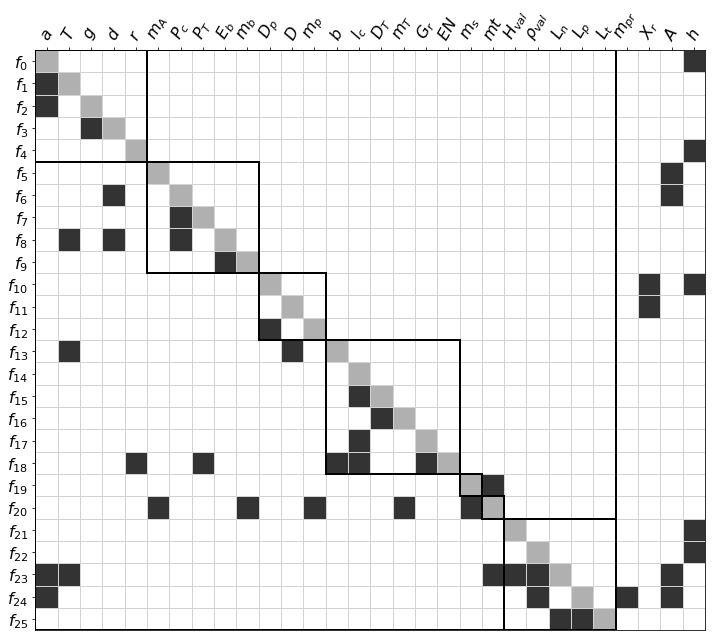

In [24]:
fig, ax = tree_incidence(m, eqv, model.outset, sequence_m, figsize=(12,12), showtree=False, pad=0);
plt.sca(ax)
plt.savefig('figures/sat.png', dpi=600, bbox_inches='tight')

### Tree & Graph

In [18]:
G, graphs = graphs_from_incidence(m, from_root=True)

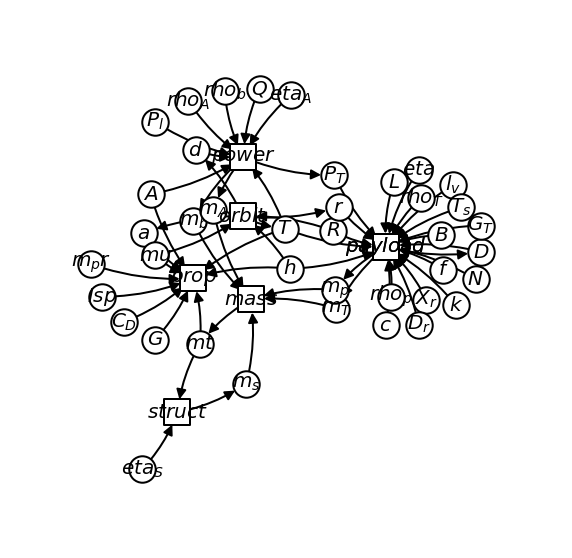

In [19]:
drawfull(graphs[m], model.eqs, figsize=(10,10))

In [20]:
m2 = make_acyclic(m, graphs)

In [21]:
render_tree(m2, display_type=True)

/               
├── orbit, SOLVER
│   ├── f_0, INTER
│   ├── f_4, INTER
│   ├── f_1, INTER
│   ├── f_2, INTER
│   └── f_3, INTER
├── power, SOLVER
│   ├── f_5, INTER
│   ├── f_6, INTER
│   ├── f_7, INTER
│   ├── f_8, INTER
│   └── f_9, INTER
├── payload, SOLVER
│   ├── f_10, INTER
│   ├── f_11, INTER
│   └── f_12, INTER
├── payload, SOLVER
│   ├── f_13, INTER
│   ├── f_14, INTER
│   ├── f_15, INTER
│   ├── f_17, INTER
│   ├── f_16, INTER
│   └── f_18, INTER
├── prop, SOLVER
│   ├── f_21, INTER
│   ├── f_22, INTER
│   ├── f_23, INTER
│   ├── f_24, INTER
│   └── f_25, INTER
└── ., SOLVER   
    ├── f_19, END
    └── f_20, END


In [29]:
notation = notation_from_tree(m2, model.outset)

# Execution order

In [33]:
execorder = generate_execution([notation])
execorder

[('exp', 0, a, 'f_0'),
 ('exp', 0, r, 'f_4'),
 ('exp', 0, T, 'f_1'),
 ('exp', 0, g, 'f_2'),
 ('exp', 0, d, 'f_3'),
 ('exp', 0, m_A, 'f_5'),
 ('exp', 0, P_c, 'f_6'),
 ('exp', 0, P_T, 'f_7'),
 ('exp', 0, E_b, 'f_8'),
 ('exp', 0, m_b, 'f_9'),
 ('exp', 0, D_p, 'f_10'),
 ('exp', 0, D, 'f_11'),
 ('exp', 0, m_p, 'f_12'),
 ('exp', 0, b, 'f_13'),
 ('exp', 0, l_c, 'f_14'),
 ('exp', 0, D_T, 'f_15'),
 ('exp', 0, G_r, 'f_17'),
 ('exp', 0, m_T, 'f_16'),
 ('exp', 0, EN, 'f_18'),
 ('exp', 0, H_val, 'f_21'),
 ('exp', 0, rho_val, 'f_22'),
 ('exp', 0, L_n, 'f_23'),
 ('exp', 0, L_p, 'f_24'),
 ('exp', 0, L_t, 'f_25'),
 ('solver', 0, 1, [m_s, mt], ['f_19', 'f_20'])]